### Referencia al ejercicio y los datos:

https://www.kaggle.com/datasets/zionfuo/drive2004

# Directorios

In [2]:
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset,random_split
# Comprobación de PyTorch y el uso de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import os, time
import numpy as np
import cv2
from glob import glob # permite leer archivos de una carpeta con un mismo formato en forma de lista 
from tqdm import tqdm # muestra barra de progreso
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate

import random
# from data import DriveDataset

from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from operator import add

import matplotlib.pyplot as plt
import random

from torch.nn import functional as F
from torchvision import transforms as T
import PIL
from PIL import Image

cuda


#### <font color=red> <p> *EXTRA*.  </font>
En caso de usar imagenes DICOM modificar con el siguiente código y biblioteca

In [ ]:
# import pydicom as dicom 

# path = "./ALGO.dcm" #directorio para elemento dicom
# x = dicom.read_file(path) # asignación de variable de lectura de archivo dicom

# Data

In [3]:
class PETdataset(Dataset):
    def __init__(self, data, masks=None, img_transforms=None, mask_transforms=False):
        '''
        data - train data path
        masks - train masks path
        '''
        self.train_data = data
        self.train_masks = masks
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.images = sorted(os.listdir(self.train_data))
        self.masks = sorted(os.listdir(self.train_masks))
        
    def __len__(self):
        if self.train_masks is not None:
            assert len(self.images)==len(self.masks), 'No coinciden el número de imágenes y máscaras'
        return len(self.images)
        
    def __getitem__(self, idx):
        image_name = os.path.join(self.train_data, self.images[idx])
        img = Image.open(image_name)
        trans = T.ToTensor()
        transm = T.Grayscale(num_output_channels=1)
        if self.img_transforms is not None:
            img = self.img_transforms(img)
        else:
            img =trans(img)
        
        if self.train_masks is not None:
            mask_name = os.path.join(self.train_masks, self.masks[idx])
            mask = Image.open(mask_name)
            mask = transm(mask)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = trans(mask)
            
            mask_max = mask.max().item()
            mask /= mask_max
        else:
            return img
        
        return img, mask

# Aumento de datos


In [ ]:
""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("\\")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "*/PET/DRIVE"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)
    print((train_x, train_y), (test_x, test_y))

    # print("\n",train_x)
    
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Creación de directorios para el aumento de datos """
    create_dir("*/DRIVE/new_data/train/image/")
    create_dir("*/DRIVE/new_data/train/mask/")
    create_dir("*/DRIVE/new_data/test/image/")
    create_dir("*/DRIVE/new_data/test/mask/")

    """ Aumento de datos """
    augment_data(train_x, train_y, "*/DRIVE/new_data/train/", augment=True)
    augment_data(test_x, test_y, "*/DRIVE/new_data/test/", augment=False)

# Directorios

In [5]:
TRAIN_PATH = "*/DRIVE/new_data/train/image/"
TRAIN_MASKS_PATH = "*/DRIVE/new_data/train/mask/"
TEST_PATH = "*/DRIVE/test/images/"

# trasformaciones

In [6]:
transform_data = T.Compose([
                T.Resize([400, 400]), #224
                T.ToTensor()] )

# Dataloaders e hiperparámetros

In [12]:
full_dataset = PETdataset(TRAIN_PATH,
                           TRAIN_MASKS_PATH,
                           img_transforms=transform_data,
                           mask_transforms=transform_data)

BATCH_SIZE = 8
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE

print(TRAIN_SIZE, VAL_SIZE)

train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

64 16
torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])


In [13]:
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)

0 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
1 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
2 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
3 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
4 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
5 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
6 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])
7 torch.Size([8, 3, 400, 400]) torch.Size([8, 1, 400, 400])


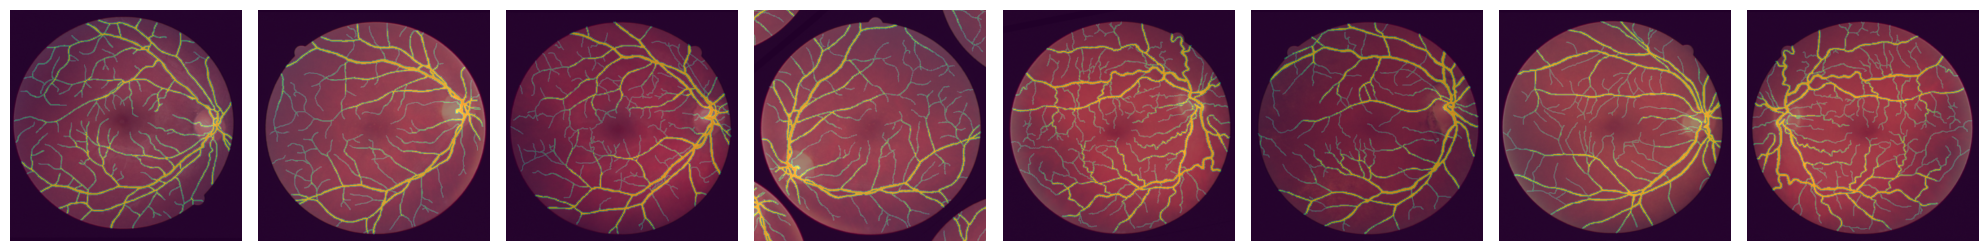

In [15]:
imgs, masks = next(iter(train_loader))
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(8):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...].permute(1,2,0).numpy()
        plt.imshow(img)
        plt.imshow(mask, alpha=0.5)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

# Loss

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Accuracy


In [36]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
           
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            # Coeficiente DICE
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            # Intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou

In [17]:
len(train_loader)

8

# Busqueda de Learning Rate óptimo

In [18]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = train_loader):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr # permite la actualización del learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    for i, (x, y) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        optimiser.zero_grad()
        scores = model(x)
        cost = F.cross_entropy(input=scores, target=y)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)
        
        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr
        
    return log_lrs, losses, accuracies

In [37]:
def train(model, optimiser, scheduler = None, epochs = 100, store_every = 25):
    model = model.to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0.
        for mb, (x, y) in enumerate(train_loader, start=1):
            model.train()
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            scores = model(x)
            cost = F.cross_entropy(input=scores, target=y)
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
            if scheduler: 
                scheduler.step()
                
            train_predictions = torch.argmax(scores, dim=1)
            train_correct_num += (train_predictions == y).sum()
            train_total += torch.numel(train_predictions)
            train_cost_acum += cost.item()
            if mb%store_every == 1:
                val_cost, val_acc, dice, iou = accuracy(model, val_loader)
                train_acc = float(train_correct_num)/train_total
                train_cost_every = float(train_cost_acum)/mb
                print(f'epoch: {epoch}, mb: {mb}, train cost: {train_cost_every:.6f}, val cost: {val_cost:.6f},'
                      f'train acc: {train_acc:.6f}, val acc: {val_acc:.6f},'
                      f'dice: {dice:.6f}, iou: {iou:.6f}')

In [38]:
torch.manual_seed(42)
model = UNET(3, 4, 2) # Asegurarse de compilar primero el modelo de UNET
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.01, momentum=0.95,
                                 weight_decay=1e-4)

lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val=1e-8, end_val=100)

cost:0.9180, lr: 0.0000, acc: 0.0630
cost:0.9364, lr: 0.0000, acc: 0.0594
cost:0.9049, lr: 0.0000, acc: 0.0619
cost:0.9147, lr: 0.0002, acc: 0.0690
cost:0.8984, lr: 0.0052, acc: 0.0670
cost:0.8210, lr: 0.1389, acc: 0.0673
cost:0.3159, lr: 3.7276, acc: 0.4905
cost:1.7341, lr: 100.0000, acc: 0.4885


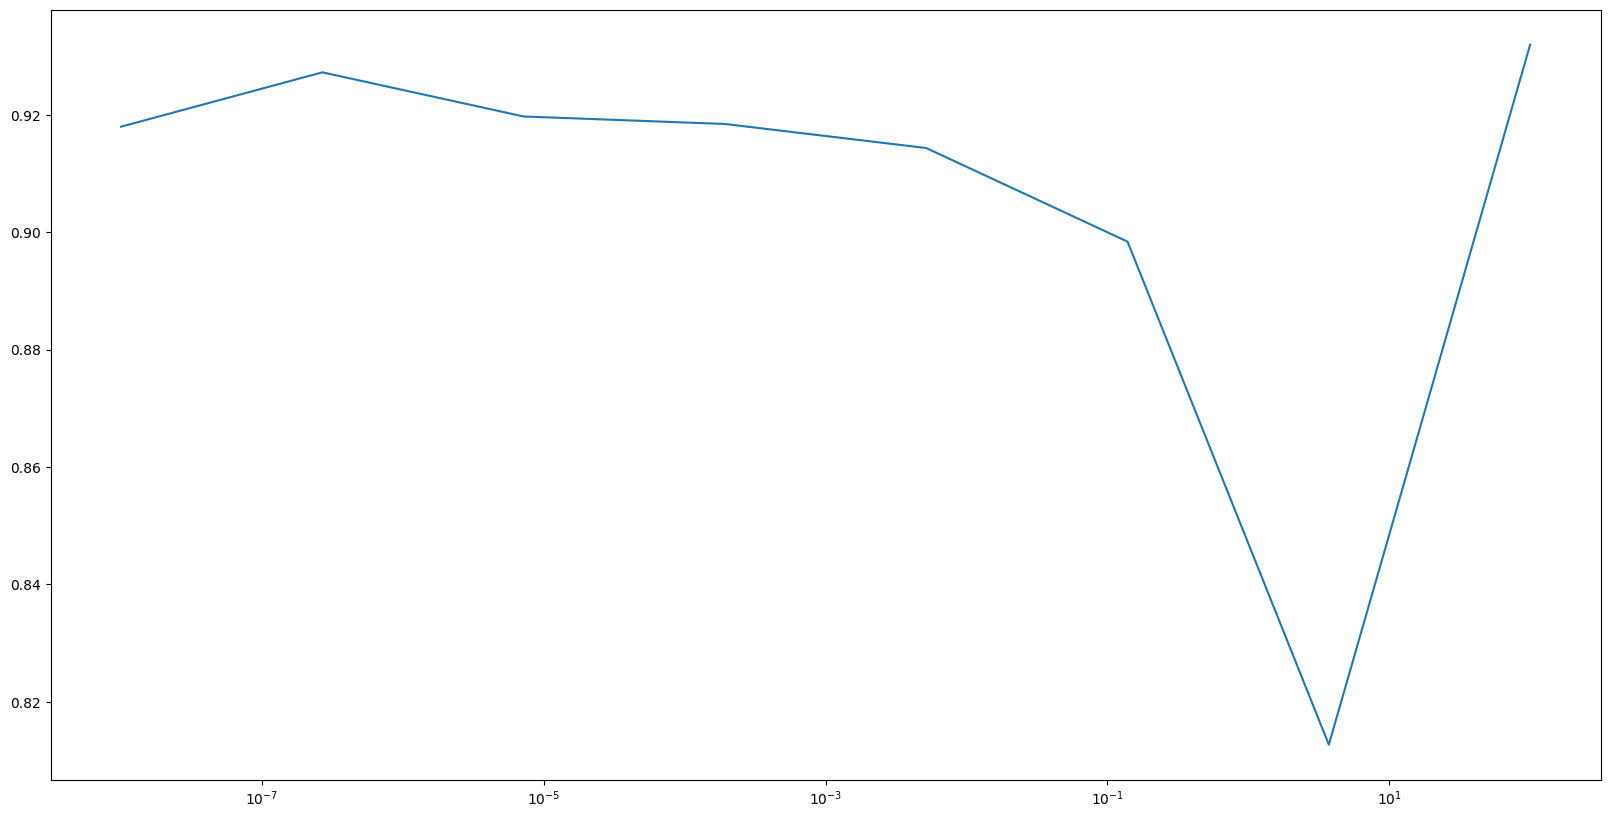

In [31]:
# plot loss vs learning rate
f1, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(lg_lr, losses)
ax1.set_xscale('log')
plt.show()

# UNET

In [20]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        return self.conv1(x)

In [21]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                           Conv_3_k(channels_in, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
            
                           Conv_3_k(channels_out, channels_out),
                           nn.BatchNorm2d(channels_out),
                           nn.ReLU(),
                            )
    def forward(self, x):
        return self.double_conv(x)
    
class Down_Conv(nn.Module):
    '''
    Down convolution part
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                        nn.MaxPool2d(2,2),
                        Double_Conv(channels_in, channels_out)
                        )
    def forward(self, x):
        return self.encoder(x)
    
class Up_Conv(nn.Module):
    '''
    Up convolution part
    '''
    def __init__(self,channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bicubic'),
                        nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1)
                        )
        self.decoder = Double_Conv(channels_in, channels_out)
    
    def forward(self, x1, x2):
        '''
        x1 - upsampled volume
        x2 - volume from down sample to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1],dim=1)
        return self.decoder(x)
    
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) # 128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) # 256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) # 512, 28, 28
        
        self.middle_conv = Down_Conv(8*channels, 16*channels) # 1024, 14, 14 
        
        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)
        
        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)
        
    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)
        
        x5 = self.middle_conv(x4)
        
        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)
        
        return self.last_conv(u4)
        

In [39]:
def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

In [40]:
preds = test()
print(preds.shape)

torch.Size([32, 2, 224, 224])


# Entrenamiento

In [43]:
torch.manual_seed(42)
model = UNET(3, 4, 2)
epochs = 300
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.1, momentum=0.95,
                                 weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

In [44]:
train(model, optimiser_unet, scheduler, epochs,10)

epoch: 0, mb: 1, train cost: 0.917997, val cost: 0.879730,train acc: 0.126001, val acc: 0.120252,dice: 0.040734, iou: 0.020791
epoch: 1, mb: 1, train cost: 0.526824, val cost: 0.474289,train acc: 0.913123, val acc: 0.947965,dice: 0.111626, iou: 0.059112
epoch: 2, mb: 1, train cost: 0.206085, val cost: 0.183483,train acc: 0.976713, val acc: 0.979073,dice: 0.000037, iou: 0.000019
epoch: 3, mb: 1, train cost: 0.120131, val cost: 0.104829,train acc: 0.974678, val acc: 0.979075,dice: 0.000000, iou: 0.000000
epoch: 4, mb: 1, train cost: 0.087473, val cost: 0.094997,train acc: 0.980929, val acc: 0.979075,dice: 0.000000, iou: 0.000000
epoch: 5, mb: 1, train cost: 0.103470, val cost: 0.085163,train acc: 0.974558, val acc: 0.979075,dice: 0.000000, iou: 0.000000
epoch: 6, mb: 1, train cost: 0.092452, val cost: 0.081813,train acc: 0.975396, val acc: 0.979075,dice: 0.000000, iou: 0.000000
epoch: 7, mb: 1, train cost: 0.079474, val cost: 0.078667,train acc: 0.978565, val acc: 0.979075,dice: 0.000000

# Test

torch.Size([8, 400, 400])


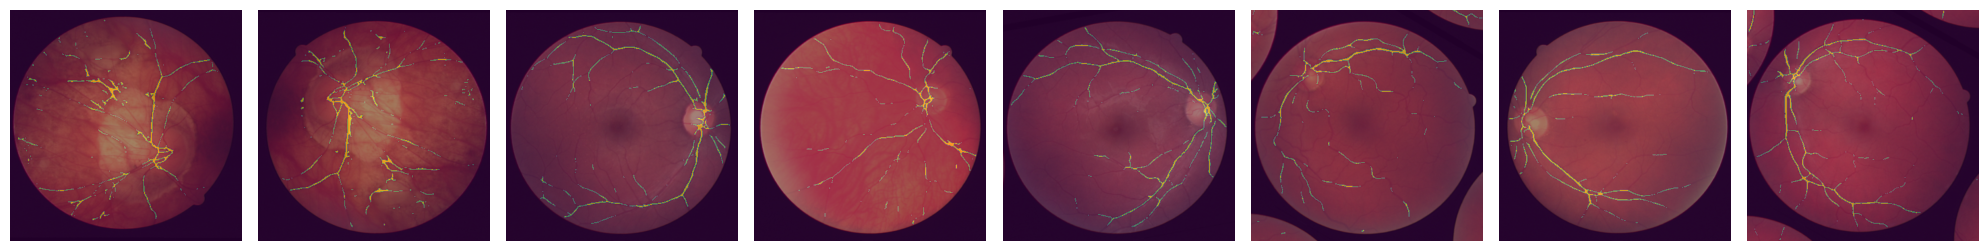

In [45]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    preds = torch.argmax(scores, dim=1).float()

imgs_val = imgs_val.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [47]:
test_set = PETdataset(TEST_PATH, img_transforms=transform_data)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([8, 400, 400])


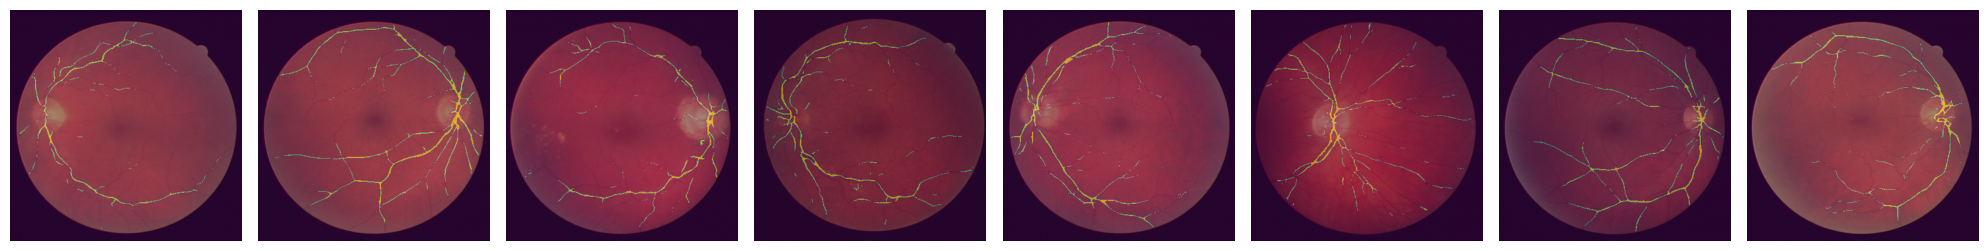

In [50]:
imgs_test = next(iter(test_loader))
imgs_test = imgs_test.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_test)
    preds = torch.argmax(scores, dim=1).float()

imgs_test = imgs_test.cpu()
preds = preds.cpu()
print(preds.shape)
plot_mini_batch(imgs_test, preds.unsqueeze(1))

#########

#########